# 15 minute city - test

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data from database

In [3]:
year = 2020

#Folder names from database
schema = 'prox_analysis'
nodes_folder = 'nodes_proximity_2020'

res = 8
c = 'Queretaro'

In [4]:
query = f"SELECT * FROM {schema}.{nodes_folder} WHERE \"metropolis\" LIKE \'{c}\'"
nodes = aup.gdf_from_query(query, geometry_col='geometry')

In [5]:
print(nodes.shape)
nodes.head(2)

(8808120, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,269701904,-100.251170,25.731077,POINT (-100.25117 25.73108),89.309483,sip_centro_admin,Monterrey
1,269701905,-100.255069,25.728568,POINT (-100.25507 25.72857),93.209377,sip_centro_admin,Monterrey


## Data treatment

### Filter hexagons without data

In [6]:
##idx = nodes['time']>0
# nodes = nodes.loc[idx]

### Remove duplicate hexagons

In [7]:
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()
print(nodes_geom.shape)
nodes_geom.head(2)

(220203, 3)


,osmid,geometry,metropolis
8412967,1757570500,POINT (-100.35931 25.70941),Monterrey
8459685,4466695139,POINT (-100.37035 25.72843),Monterrey


### Rows to columns

In [8]:
nodes_analysis = nodes_geom.copy()

for amenidad in list(nodes.amenity.unique()):
    nodes_tmp = nodes.loc[nodes.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
print(nodes_analysis.shape)
nodes_analysis.head(2)

(179057, 43)


,osmid,geometry,metropolis,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,...,denue_pintura,denue_peluqueria,sip_teatro,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel
0,269701904,POINT (-100.25117 25.73108),Monterrey,89.309483,13.681485,14.804288,23.560786,8.035155,44.942055,12.701263,...,15.904288,9.179475,80.254027,147.561441,57.517007,7.878787,97.031992,23.679311,29.784430,71.143685
1,269701905,POINT (-100.25507 25.72857),Monterrey,93.209377,17.151717,10.896676,26.163203,14.101206,38.406648,10.527316,...,23.417647,13.682406,84.153921,140.193274,63.583058,7.492027,100.840331,22.805551,35.850481,67.772490


<AxesSubplot:>

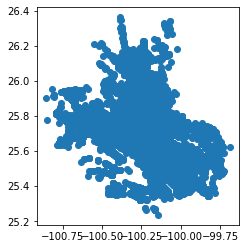

In [9]:
nodes_analysis.plot()

## 15 minute analysis

### Parameters definitions

In [10]:
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                         'Primaria':['denue_primaria'],
                         'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                      'Gobierno':['sip_centro_admin'],
                                      'Cuidado':['denue_guarderias','denue_casa_adultos_mayores',
                                                'denue_dif']},
              'Comercio':{'Básicos':['denue_supermercado','denue_abarrotes',
                                    'denue_carnicerias','sip_mercado'],
                         'Personal':['denue_peluqueria','denue_farmacias'],
                         'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                         'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                           'denue_lavanderia','denue_revistas_periodicos',
                                           'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                          'denue_bares','denue_cafe'],
                                'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                   'sip_espacio_publico','denue_parque_natural'],
                                'Cultural':['denue_cines','denue_museos']} 
             }

wegiht_idx = {'Escuelas':{'Preescolar':0.333,
                         'Primaria':0.333,
                         'Secundaria':0.333},
             'Servicios comunitarios':{'Salud':0.333,
                                      'Gobierno':0.333,
                                      'Cuidado':0.333},
              'Comercio':{'Básicos':0.3,
                         'Personal':0.3,
                         'Hogar':0.3,
                         'Complementarios':0.1},
              'Entretenimiento':{'Social':0.333,
                                'Actividad física':0.333,
                                'Cultural':0.333}
             }

tiempos_15_min = {'denue_preescolar':[5,'peatonal'],
                 'denue_primaria':[5,'peatonal'],
                 'denue_secundaria':[15,'peatonal'],
                  'denue_escuela_mixta':[15,'peatonal'],
                 'clues_primer_nivel':[5,'peatonal'],
                 'sip_centro_admin':[15,'bicicleta'],
                 'denue_guarderias':[10,'peatonal'],
                 'denue_casa_adultos_mayores':[5,'peatonal'],
                 'denue_dif':[15,'bicicleta'],
                 'denue_supermercado':[5,'peatonal'],
                 'denue_abarrotes':[5,'peatonal'],
                 'denue_carnicerias':[5,'peatonal'],
                 'sip_mercado':[5,'peatonal'],
                 'denue_peluqueria':[15,'bicicleta'],
                  'denue_farmacias':[15,'peatonal'],
                  'denue_ferreteria_tlapaleria':[15,'peatonal'],
                  'denue_art_limpieza':[15,'peatonal'],
                  'denue_ropa':[15,'peatonal'],
                  'denue_calzado':[15,'peatonal'],
                  'denue_muebles':[15,'peatonal'],
                  'denue_lavanderia':[15,'peatonal'],
                  'denue_revistas_periodicos':[15,'peatonal'],
                  'denue_pintura':[15,'peatonal'],
                  'denue_restaurante_insitu':[15,'peatonal'],
                  'denue_restaurante_llevar':[15,'peatonal'],
                  'denue_bares':[15,'peatonal'],
                  'denue_cafe':[15,'peatonal'],
                  'sip_cancha':[5,'peatonal'],
                  'sip_unidad_deportiva':[5,'peatonal'],
                  'sip_espacio_publico':[5,'peatonal'],
                  'denue_parque_natural':[15,'bicicleta'],
                  'denue_cines':[15,'bicicleta'],
                  'denue_museos':[15,'bicicleta']
                 }

### Analysis

In [11]:
nodes_15_min = nodes_analysis.copy()

for amenidad in list(tiempos_15_min.keys()):
    idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
    nodes_15_min[idx_column_name] = 0
    
    if nodes_15_min[amenidad][1] == 'peatonal':
        tiempo_limite = tiempos_15_min[amenidad][0]
    else:
        tiempo_limite = tiempos_15_min[amenidad][0] * 3
        
    idx_amenidad = nodes_15_min[amenidad] <= tiempo_limite
    nodes_15_min.loc[idx_amenidad, idx_column_name] = 1
    

In [13]:
cat_list = []
raw_cat_list = []

for cat in idx_15_min.keys():
    
    cat_list.append(cat)
    raw_cat_list.append('raw_'+cat)
    
    subcat_list = []
    raw_subcat_list = []
    
    for subcat in idx_15_min[cat]:
        
        subcat_list.append(subcat)
        raw_subcat_list.append('raw_'+subcat)
                
        subcat_amenities_list = []
        
        for amenidad in idx_15_min[cat][subcat]:
            
            idx_column_name = 'idx' + amenidad[amenidad.find('_'):]
            subcat_amenities_list.append(idx_column_name)
            
        nodes_15_min['raw_'+subcat] = (nodes_15_min[subcat_amenities_list].sum(axis=1) / len(subcat_amenities_list)) * wegiht_idx[cat][subcat]
        
        idx = nodes_15_min['raw_'+subcat] > 0
        nodes_15_min[subcat] = 0
        nodes_15_min.loc[idx, subcat] = 1 * wegiht_idx[cat][subcat]
        
    nodes_15_min[cat] = nodes_15_min[subcat_list].sum(axis=1)
    nodes_15_min['raw_'+cat] = nodes_15_min[raw_subcat_list].sum(axis=1)
    
nodes_15_min['15_min_analysis'] = nodes_15_min[cat_list].sum(axis=1)
nodes_15_min['raw_15_min_analysis'] = nodes_15_min[raw_cat_list].sum(axis=1)

            

(-100.91477568, -99.62899712, 25.178411630000003, 26.41907237)

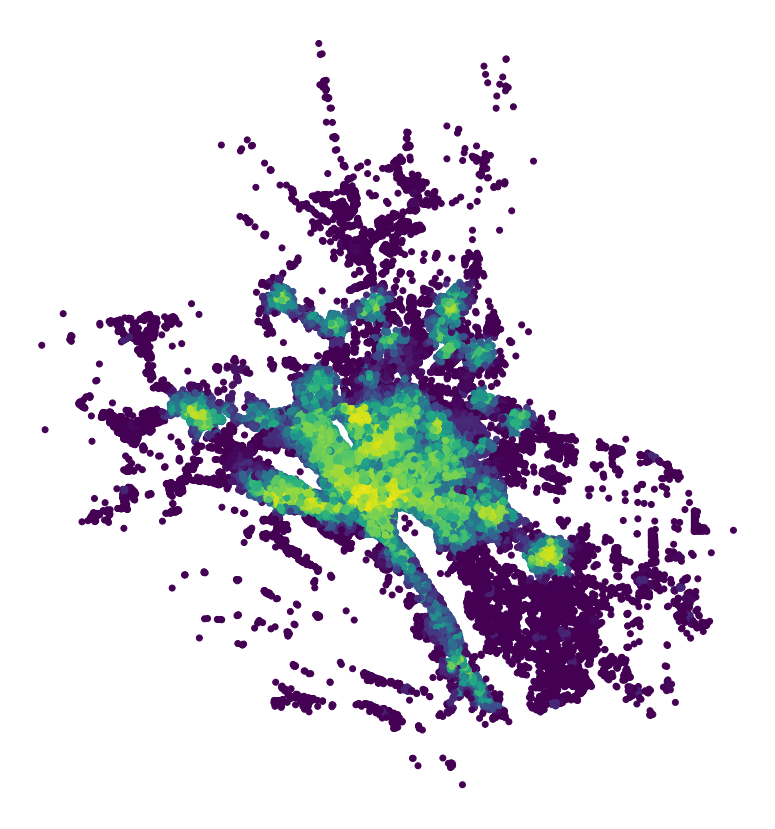

In [14]:
fig, ax = plt.subplots(figsize=(15,15))


nodes_15_min.plot('raw_15_min_analysis',ax=ax)

ax.axis('off')

In [14]:
nodes_15_min

,hex_id_8,geometry,metropolis,sip_centro_admin,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,...,raw_Social,Social,raw_Actividad física,Actividad física,raw_Cultural,Cultural,Entretenimiento,raw_Entretenimiento,15_min_analysis,raw_15_min_analysis
0,8849abc953fffff,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",Guadalajara,65.318199,69.859240,62.333784,79.503812,90.412665,87.992587,108.843417,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000
1,8849ab5249fffff,"POLYGON ((-103.66904 20.45140, -103.66452 20.4...",Guadalajara,69.876499,60.853512,68.055191,142.976986,153.885839,166.402297,80.672697,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000
2,8849aa26cdfffff,"POLYGON ((-103.55846 20.41500, -103.55792 20.4...",Guadalajara,114.515742,101.296303,99.194075,110.885833,115.539102,119.141723,174.991435,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000
3,8849abc9a9fffff,"POLYGON ((-103.59961 20.43722, -103.60016 20.4...",Guadalajara,56.189744,50.835299,49.620429,51.227824,57.305821,69.912618,75.134255,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.300,0.150000
4,8849ab526dfffff,"POLYGON ((-103.63735 20.47287, -103.64188 20.4...",Guadalajara,91.524145,89.451808,95.139389,151.506481,162.415334,174.931792,89.966213,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,88498c9119fffff,"POLYGON ((-103.12270 20.60904, -103.12724 20.6...",Guadalajara,98.649753,93.549049,90.913454,94.815846,97.905578,83.422639,92.859291,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000
2988,88498c9337fffff,"POLYGON ((-103.11952 20.57787, -103.12405 20.5...",Guadalajara,17.911420,12.871774,15.665258,11.379944,71.425713,114.464810,66.029918,...,0.1665,0.333,0.0,0.0,0.0,0.0,0.333,0.1665,1.699,1.315833
2989,88498c9addfffff,"POLYGON ((-103.08237 20.64169, -103.08744 20.6...",Guadalajara,47.232760,28.775424,40.006352,41.074586,53.597215,58.762834,49.836279,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.633,0.261000
2990,88498c9303fffff,"POLYGON ((-103.13607 20.55009, -103.13554 20.5...",Guadalajara,66.815042,61.702130,65.417979,81.626257,75.239786,170.423798,69.843992,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.000,0.000000


In [16]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Ciudad_15_min/'
nodes_15_min.to_file(grl_dir+f'Medio_Urbano/Analisis/{c}_15min_Analisis_nodes.geojson', driver='GeoJSON')

## Priority time average

In [70]:
priority_amenities = ['osmid','denue_preescolar','denue_primaria','denue_secundaria',
                     'clues_primer_nivel','denue_guarderias','denue_casa_adultos_mayores',
                     'denue_supermercado','denue_abarrotes', 'denue_carnicerias',
                     'sip_mercado','sip_cancha','sip_unidad_deportiva',
                     'sip_espacio_publico','denue_parque_natural','geometry']
nodes_15_min_priority = nodes_analysis[priority_amenities].copy()
print(nodes_15_min_priority.shape)
nodes_15_min_priority.head(2)

(179057, 16)


,osmid,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_casa_adultos_mayores,denue_supermercado,denue_abarrotes,denue_carnicerias,sip_mercado,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,denue_parque_natural,geometry
0,269701904,13.681485,14.804288,23.560786,23.679311,12.701263,44.942055,20.203180,9.179475,6.306829,97.031992,147.561441,57.517007,7.878787,135.512270,POINT (-100.25117 25.73108)
1,269701905,17.151717,10.896676,26.163203,22.805551,10.527316,38.406648,24.697034,8.273776,1.206530,100.840331,140.193274,63.583058,7.492027,132.141076,POINT (-100.25507 25.72857)


In [71]:
nodes_15_min_priority['alimentos'] = nodes_15_min_priority[['denue_supermercado','denue_abarrotes',
                                                            'denue_carnicerias','sip_mercado']].min(axis=1)
nodes_15_min_priority = nodes_15_min_priority.drop(columns=['denue_supermercado','denue_abarrotes',
                                                            'denue_carnicerias','sip_mercado'])
nodes_15_min_priority['unidad_cancha'] = nodes_15_min_priority[['sip_cancha','sip_unidad_deportiva']].min(axis=1)
nodes_15_min_priority = nodes_15_min_priority.drop(columns=['sip_cancha','sip_unidad_deportiva'])

In [72]:
nodes_15_min_priority.head(4)

,osmid,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_casa_adultos_mayores,sip_espacio_publico,denue_parque_natural,geometry,alimentos,unidad_cancha
0,269701904,13.681485,14.804288,23.560786,23.679311,12.701263,44.942055,7.878787,135.512270,POINT (-100.25117 25.73108),6.306829,57.517007
1,269701905,17.151717,10.896676,26.163203,22.805551,10.527316,38.406648,7.492027,132.141076,POINT (-100.25507 25.72857),1.206530,63.583058
2,286524990,11.605419,8.739190,9.296775,7.181717,4.213875,30.025120,10.343406,131.780115,POINT (-100.30030 25.67256),5.522837,49.771771
3,286525001,9.841630,9.841630,10.538315,5.841740,6.591375,32.383299,6.988179,134.170980,POINT (-100.29826 25.67270),4.644346,46.457611


In [73]:
schema = 'prox_analysis'
hex_folder = 'hex_bins_proximity_2020'

query = f"SELECT hex_id_8,geometry FROM {schema}.{hex_folder} WHERE \"metropolis\" LIKE \'{c}\'"

hex_bins = aup.gdf_from_query(query, geometry_col='geometry')

In [74]:
hex_bins = hex_bins.drop_duplicates(subset='hex_id_8', keep="last")[['hex_id_8','geometry']].copy()
print(hex_bins.shape)
hex_bins.head(2)

(8846, 2)


,hex_id_8,geometry
344953,8848a22165fffff,"POLYGON ((-100.38848 25.97748, -100.38891 25.9..."
344954,8848a23abbfffff,"POLYGON ((-100.42307 25.91239, -100.42783 25.9..."


In [75]:
col_name = 'denue_preescolar'
hex_dist = aup.group_by_hex_mean(nodes_15_min_priority, hex_bins, res, col_name)

<AxesSubplot:>

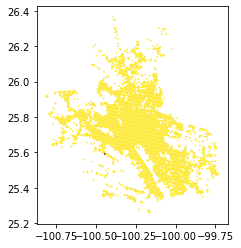

In [76]:
hex_dist['mean_time'] = hex_dist[['denue_preescolar','denue_primaria','denue_secundaria',
                     'clues_primer_nivel','denue_guarderias','denue_casa_adultos_mayores',
                     'alimentos','unidad_cancha','sip_espacio_publico']] .mean(axis=1)
idx = hex_dist.mean_time != 0
hex_dist = hex_dist[idx]

hex_dist.plot('mean_time', 'viridis_r')

In [77]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Ciudad_15_min/'
hex_dist.to_file(grl_dir+f'Medio_Urbano/Analisis/{c}_Priority_15min_Analisis.geojson', driver='GeoJSON')

In [78]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Vivienda_Deshabitada/'
hex_pop = gpd.read_file(grl_dir+f'Info_Sociodemografica/Analisis/Block_Census/{c}_Census_10_20_BlockAnalysis_res{res}.geojson', driver='GeoJSON')
hex_pop = hex_pop[['hex_id_8','pobtot','dens_pob_ha','T_Pob_10_20']]
print(hex_pop.shape)
hex_pop.head(2)

(1490, 4)


,hex_id_8,pobtot,dens_pob_ha,T_Pob_10_20
0,8848a205b1fffff,10619.0,123.674370,3557.0
1,8848a21105fffff,304.0,3.544947,207.0


In [79]:
hex_mrg = hex_dist.merge(hex_pop, on='hex_id_8', how='right')
print(hex_mrg.shape)
hex_mrg.head(2)

(1490, 16)


,hex_id_8,geometry,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_casa_adultos_mayores,sip_espacio_publico,denue_parque_natural,alimentos,unidad_cancha,mean_time,pobtot,dens_pob_ha,T_Pob_10_20
0,8848a205b1fffff,"POLYGON ((-100.33358 25.79790, -100.32883 25.8...",8.176518,8.238395,25.007824,13.141857,10.672285,122.195904,3.575947,324.930549,2.176200,41.140800,26.036192,10619.0,123.674370,3557.0
1,8848a21105fffff,"POLYGON ((-100.15667 25.46413, -100.16184 25.4...",26.277889,21.310980,71.529436,34.619927,74.778090,89.763489,32.946369,235.667655,14.549606,412.048757,86.424949,304.0,3.544947,207.0


In [80]:
hex_mrg.mean()

denue_preescolar                20.039657
denue_primaria                  21.282322
denue_secundaria                35.646269
clues_primer_nivel              24.966359
denue_guarderias                38.388170
denue_casa_adultos_mayores     120.685696
sip_espacio_publico             13.883351
denue_parque_natural           292.409971
alimentos                       11.225455
unidad_cancha                  136.262952
mean_time                       46.931137
pobtot                        3532.389262
dens_pob_ha                     41.154160
T_Pob_10_20                    747.392617
dtype: float64

<AxesSubplot:>

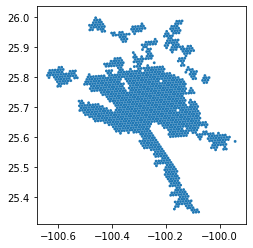

In [81]:
hex_mrg.plot()

In [82]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Ciudad_15_min/'
hex_mrg.to_file(grl_dir+f'Medio_Urbano/Analisis/{c}_Priority_15min_Analisis.geojson', driver='GeoJSON')